# Illustrated Markov Decision Process

Companion to courses lectures from [CS6756: Learning for Robot Decision Making](https://www.cs.cornell.edu/courses/cs6756/2022fa/) and Chapter 1, 5 of [Modern Adaptive Control and Reinforcement Learning](https://drive.google.com/file/d/1SGMdtjpP8-Yxga2ph-tUWBcFx5cH89t2/view).

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.figure import figaspect
from IPython.display import HTML, Image
from matplotlib import rc
from matplotlib.colors import ListedColormap
rc('animation', html='jshtml')

# Making of a Finite Horizon, Deterministic MDP 🌱

## Building the map 🏗

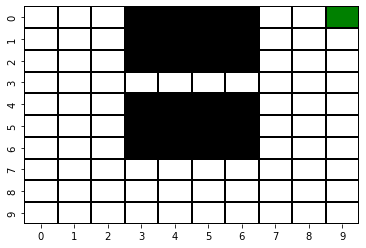

In [24]:
# Let's create a world with a swamp, a bridge across it, and a goal. 
# We will represent this as a 2D array with cell values
# 0= swamp, 1=traversable, 2=goal
map = np.ones((10,10))
swamp = {'xlim': [0,7], 'ylim':[3,7]}
bridge = {'xlim': [3,4], 'ylim':[3,7]}
goal = [0,9]
map[swamp['xlim'][0]:swamp['xlim'][1], swamp['ylim'][0]:swamp['ylim'][1]] = 0
map[bridge['xlim'][0]:bridge['xlim'][1], bridge['ylim'][0]:bridge['ylim'][1]] = 1
map[goal[0], goal[1]] = 2

# Visualize map
ax = sns.heatmap(map, cmap=ListedColormap(['black', 'white', 'green']), linewidths=1, linecolor='black', cbar=False)

You can see in the map above that the goal is on the top right corner. A robot will typically start off in the top left corner. There are two ways to get to the goal
1.   By crossing the bridge across the swamp
2.   By taking a long detour around the swamp

We will see the different paths the robot chooses depending on the dynamics of the world.

## Defining the MDP 🌎

In [25]:
# Let's create the MDP
# States are coordinates
# Actions are 0 (stop), 1 (right), 2 (down), 3 (left), 4(right)
A = [(0,0), (0,1), (1, 0), (0, -1), (-1, 0)]
# Transition function: You deterministically transition according to your action 
# except: 
# (1) If you are in a swamp, you stay in a swamp 
# (2) If you try to leave the map, you stay where you are
def T(sx, sy, a):
  if map[sx, sy] == 0:
    a = 0
  return (max(0, min(sx + A[a][0], map.shape[0]-1)), max(0, min(sy + A[a][1], map.shape[1]-1)))

# Cost
C = lambda sx, sy, a: 0 if map[sx, sy]==2 else 1 

# Horizon of the MDP
H = 30

# Value Iteration by Dynamic Programming ⏳

## Let's do value iteration backwards in time

In [ ]:
# V values for all state at all times. Shape: [Horizon, Sx, Sy]
V_t = np.zeros((H, map.shape[0], map.shape[1]))
# Deterministic policy for all state at all times. Shape: [Horizon, Sx, Sy]
Pi_t = np.zeros((H, map.shape[0], map.shape[1]), dtype=int)

# Iterate backwards in time
for t in range(H-1, -1, -1):
  Q = np.zeros((map.shape[0], map.shape[1], len(A)))
  for (sx, sy, a) in np.ndindex(map.shape[0], map.shape[1], len(A)):
    Q[sx, sy, a] = C(sx, sy, a) + V_t[t+1, T(sx, sy, a)[0], T(sx, sy, a)[1]] if t < H-1 else C(sx, sy, a)
  V_t[t] = Q.min(axis=-1)
  Pi_t[t] = Q.argmin(axis=-1)

## Visualizing the value function and optimal policy

In [10]:
# Function for creating an animation of values and policies
def animate_value_policies(V_t, Pi_t, save_filename=None):
  fig, ax = plt.subplots(1,2, figsize=figaspect(0.3))
  arrows = np.array(['✗', '→', '↓', '←', '↑'])
  fig.suptitle('Time: 0')

  def plot_value_policy(i):
      """Update the animation at frame i."""
      t = H-i-1
      ax[0].clear()
      sns.heatmap(V_t[t], cmap="YlGnBu", annot=True, ax=ax[0], cbar=False, annot_kws={'color':'k'})
      ax[1].clear()
      sns.heatmap(V_t[t], cmap="YlGnBu", annot=arrows[Pi_t[t]], fmt='', cbar=False, ax=ax[1], annot_kws={'color':'k'})
      fig.suptitle('Time: {}'.format(t))

  anim = FuncAnimation(fig, plot_value_policy, frames=H, blit=False, repeat=False)
  if save_filename is not None:
    anim.save(save_filename, writer = "pillow", fps=3)  
  return anim

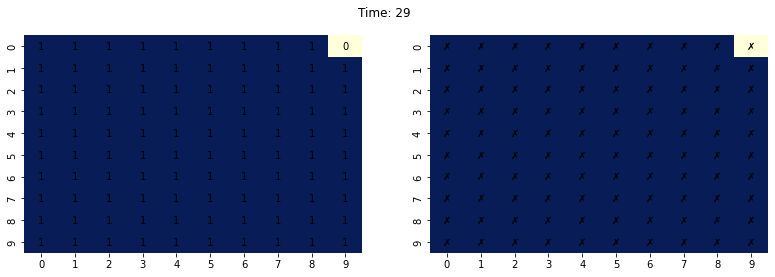

In [ ]:
animate_value_policies(V_t, Pi_t, 'value_iter_deterministic_finite_horizon.gif')

# Turning things stochastic 🌪

## Making a slippery bridge ⛸ 

So far things have been pretty deterministic. The robot could perfectly travel wherever it wanted. Now we are going to make things interesting by making the bridge slippery. This means that with some probability, the robot may end up in any of the other 4 cells than what it intended. 

In [7]:
def P(sx, sy, a, p_slip=0.5):
  p = p_slip if (sx>=bridge['xlim'][0] and sx <bridge['xlim'][1] and sy >= bridge['ylim'][0] and sy <bridge['ylim'][1]) else 0
  P_nominal = np.zeros(map.shape)
  P_nominal[T(sx, sy, a)] = 1.0

  P_unif = np.zeros(map.shape)
  for a in range(len(A)):
    P_unif[T(sx, sy, a)] = 1.0
  P_unif = P_unif / P_unif.sum()

  return (1-p)*P_nominal + p*P_unif

## Value Iteration by Dyanmic Programming for Stochastic Environments

In [ ]:
# V values for all state at all times. Shape: [Horizon, Sx, Sy]
V_t = np.zeros((H, map.shape[0], map.shape[1]))
# Deterministic policy for all state at all times. Shape: [Horizon, Sx, Sy]
Pi_t = np.zeros((H, map.shape[0], map.shape[1]), dtype=int)

# Iterate backwards in time
for t in range(H-1, -1, -1):
  Q = np.zeros((map.shape[0], map.shape[1], len(A)))
  for (sx, sy, a) in np.ndindex(map.shape[0], map.shape[1], len(A)):
    Q[sx, sy, a] = C(sx, sy, a) + np.sum(P(sx, sy, a) * V_t[t+1, :, :]) if t < H-1 else C(sx, sy, a)
  V_t[t] = Q.min(axis=-1)
  Pi_t[t] = Q.argmin(axis=-1)

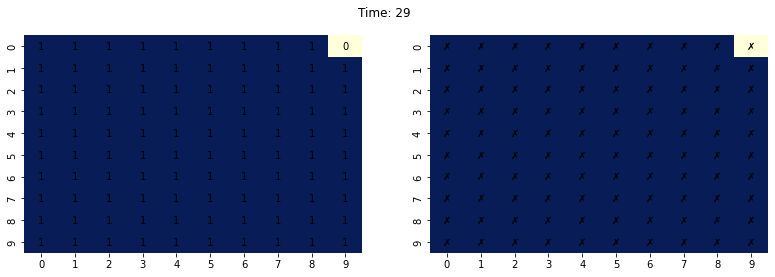

In [ ]:
animate_value_policies(V_t, Pi_t, 'value_iter_stochastic_finite_horizon.gif')

# To Infinity and Beyond! 🚀

## Defining an infinite horizon MDP ♾

So far things have been upto a finite horizon. Let's stretch the horizon to infinity. Now that comes with a price:


*   We can no longer expect value iteration to converge
*   Even if it did converge, we don't have the space to story all the values over time

To solve the first problem, we need to introduce a discount factor $γ < 1$. Think of $1 / (1-γ)$ being an effective horizon. 
To solve the second problem, we will use the Bellman equation and find the fixed point of value iteration 

In [26]:
def value_iteration(C, P, gamma, max_iter=100, convergence_thresh=0.01):
  # V values for all state at all iterations. Shape: [max_iters, Sx, Sy]
  V_k = np.zeros((max_iter, map.shape[0], map.shape[1]))
  # Deterministic policy for all state at all iters. Shape: [max_iters, Sx, Sy]
  Pi_k = np.zeros((max_iter, map.shape[0], map.shape[1]), dtype=int)

  for k in range(1, max_iter):
    Q = np.zeros((map.shape[0], map.shape[1], len(A)))
    for (sx, sy, a) in np.ndindex(map.shape[0], map.shape[1], len(A)):
      Q[sx, sy, a] = C(sx, sy, a) + gamma*np.sum(P(sx, sy, a) * V_k[k-1, :, :]) 
    V_k[k] = Q.min(axis=-1)
    Pi_k[k] = Q.argmin(axis=-1)
  
  return V_k, Pi_k

In [27]:
# Function for creating an animation of values and policies
def animate_value_policies_iter(V_k, Pi_k, save_filename=None):
  fig, ax = plt.subplots(1,2, figsize=figaspect(0.3))
  arrows = np.array(['✗', '→', '↓', '←', '↑'])
  fig.suptitle('Time: 0')

  def plot_value_policy(i):
    """Update the animation at frame i."""
    ax[0].clear()
    sns.heatmap(V_k[i], cmap="YlGnBu", annot=True, ax=ax[0], cbar=False)
    ax[1].clear()
    sns.heatmap(V_k[i], cmap="YlGnBu", annot=arrows[Pi_k[i]], fmt='', cbar=False, ax=ax[1])
    fig.suptitle('Iter: {}'.format(i))

  anim = FuncAnimation(fig, plot_value_policy, frames=len(V_k), blit=False, repeat=False)
  if save_filename is not None:
    anim.save(save_filename, writer = "pillow", fps=3)  
  return anim

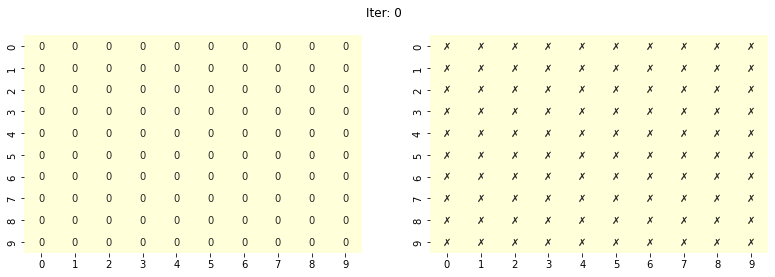

In [28]:
V_k, Pi_k = value_iteration(C, P, gamma=0.99, max_iter=30)
animate_value_policies_iter(V_k, Pi_k, 'value_iter_stochastic_infinite_horizon.gif')

## Policy Iteration 🔃

When we run value iteration, we sometimes see the policy converge while the values continue being updated. This suggests an alternate algorithm -- guess a policy, evaluate it's value, improve the policy and repeat. As we see below, this can sometinmes converge much faster than value iteration. 

In [31]:
# TODO: Make into a nice function

max_iters = 10
V_k = np.zeros((max_iters, map.shape[0], map.shape[1]))
Pi_k = np.zeros((max_iters, map.shape[0], map.shape[1]), dtype=int)

# Initialize policy
Pi_k[0, :, :] = 1
Pi_k[0, :, -1] = 4

gamma = 0.99
for k in range(1, max_iters):
  # Evaluate policy
  for t in range(H-1, -1, -1):
    for (sx, sy, a) in np.ndindex(map.shape[0], map.shape[1], len(A)):
      V_k[k, sx, sy] = C(sx, sy, Pi_k[k-1, sx, sy]) + gamma*np.sum(P(sx, sy, Pi_k[k-1, sx, sy]) * V_k[k, :, :]) if t < H-1 else C(sx, sy, Pi_k[k-1, sx, sy])

  # Improve policy
  Q = np.zeros((map.shape[0], map.shape[1], len(A)))
  for (sx, sy, a) in np.ndindex(map.shape[0], map.shape[1], len(A)):
      Q[sx, sy, a] = C(sx, sy, a) + gamma*np.sum(P(sx, sy, a) * V_k[k, :, :]) 
  Pi_k[k] = Q.argmin(axis=-1)

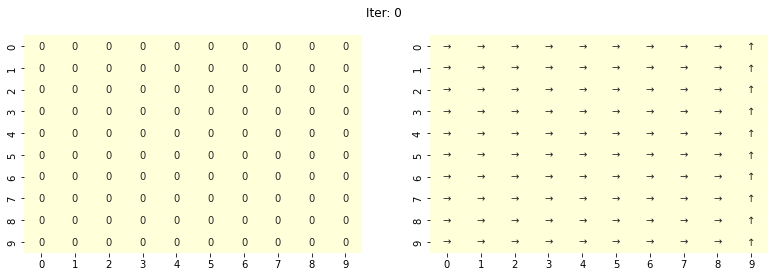

In [30]:
animate_value_policies_iter(V_k, Pi_k, 'policy_iter_stochastic_infinite_horizon.gif')

# Messing with MDPs 😎

Now let's have some fun messing around with MDP parameters and seeing how the optimal policy changes. 

## Variation of Values with Gamma (γ)

How does the optimal policy vary if we change γ? Recall γ is the discount factor. γ=0 means that we care only about immediate costs and nothing else. The more we increase γ, the more we care about future costs. Can you explain what happens to the policy on the bridge as we increase γ?


In [32]:
V_list = []
Pi_list = []
gamma_list = np.linspace(0, 0.99, 10, endpoint=True)
for gamma in gamma_list:
  V_k, Pi_k = value_iteration(C, P, gamma=gamma, max_iter=30)
  V_list += [V_k[-1]]
  Pi_list += [Pi_k[-1]]

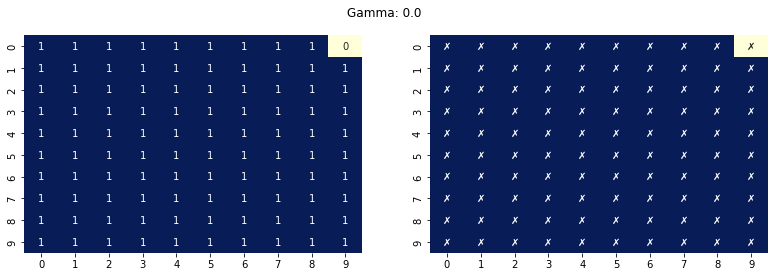

In [33]:
#TODO we could have used previous visualization code if we passed in a function 
# pointer to display the title.

fig, ax = plt.subplots(1,2, figsize=figaspect(0.3))
arrows = np.array(['✗', '→', '↓', '←', '↑'])
fig.suptitle('Time: 0')

def plot_value_policy(i):
    """Update the animation at frame i."""
    ax[0].clear()
    sns.heatmap(V_list[i], cmap="YlGnBu", annot=True, ax=ax[0], cbar=False)
    ax[1].clear()
    sns.heatmap(V_list[i], cmap="YlGnBu", annot=arrows[Pi_list[i]], fmt='', cbar=False, ax=ax[1])
    fig.suptitle(f'Gamma: {gamma_list[i]}')

anim = FuncAnimation(fig, plot_value_policy, frames=len(V_list), blit=False, repeat=False)
anim.save('variation_with_gamma.gif', writer = "pillow", fps=2)  
anim

## Variation with slipperiness of the bridge

What happens as we change the slipperiness of the bridge?


In [34]:
V_list = []
Pi_list = []
p_slip_list = np.linspace(0, 1.0, 10, endpoint=True)
for p_slip in p_slip_list:
  P_current = lambda sx, sy, a: P(sx, sy, a, p_slip = p_slip)
  V_k, Pi_k = value_iteration(C, P_current, gamma=gamma, max_iter=30)
  V_list += [V_k[-1]]
  Pi_list += [Pi_k[-1]]

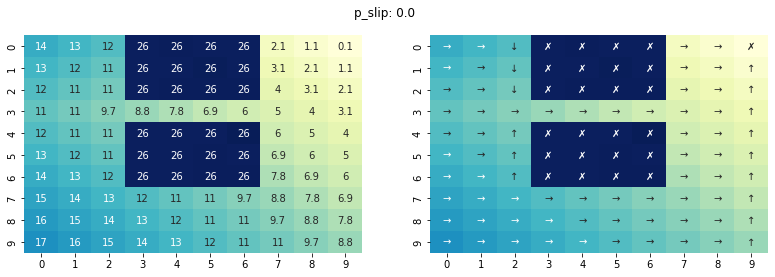

In [22]:
fig, ax = plt.subplots(1,2, figsize=figaspect(0.3))
arrows = np.array(['✗', '→', '↓', '←', '↑'])
fig.suptitle('Time: 0')

def plot_value_policy(i):
    """Update the animation at frame i."""
    ax[0].clear()
    sns.heatmap(V_list[i], cmap="YlGnBu", annot=True, ax=ax[0], cbar=False)
    ax[1].clear()
    sns.heatmap(V_list[i], cmap="YlGnBu", annot=arrows[Pi_list[i]], fmt='', cbar=False, ax=ax[1])
    fig.suptitle(f'p_slip: {p_slip_list[i]}')

anim = FuncAnimation(fig, plot_value_policy, frames=len(V_list), blit=False, repeat=False)
anim.save('variation_with_p_slip.gif', writer = "pillow", fps=2)  
anim